In [1]:
import os
import sys
import glob
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import jax
# set 64-bit mode
jax.config.update("jax_enable_x64", True)


from scipy import signal, interpolate, stats
sys.path.append("/home/michael/Synology/Desktop/Data/Python/NeuralODE/DDFA_NODE/")
from ddfa_node import embed_data, takens_embedding, change_trial_length, split_data, get_aics, get_λs, phaser, stats as statistics, jax_utils

from tqdm.auto import tqdm
import torch

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.metrics import mean_squared_error
from scipy.signal import savgol_filter

import warnings
%load_ext autoreload
%autoreload 2

In [17]:

data_loc = "data/Modelingandanalysis-latest/"
files = glob.glob(data_loc + "/**/*K0.csv", recursive=True)
df = pd.read_csv(files[0])
df["Subject"] = 0
for idx, file in enumerate(files[1:]):
    df1 = pd.read_csv(file)
    df1["Subject"] = idx + 1
    df = pd.concat((df, df1))
    
df = df[["hip_flexion_r", "hip_flexion_l", "knee_angle_r", "knee_angle_l", "ankle_angle_r", "ankle_angle_l", "Subject"]]
window_length = 30
polyorder = 5
feats = ["hip_flexion_l", "knee_angle_l", "ankle_angle_l", "hip_flexion_r",  "knee_angle_r", "ankle_angle_r"]
n_subjects = len(df["Subject"].unique())
total_steps = len(df)
data = np.zeros((n_subjects, total_steps // n_subjects, len(feats) * 2)) # 2x the features for velocity
for subject in range(n_subjects):
    data[subject, :, :len(feats)] = savgol_filter(df[df["Subject"] == subject][feats].to_numpy(), window_length=window_length, polyorder=polyorder, axis=0)
    data[subject, :, len(feats):] = savgol_filter(df[df["Subject"] == subject][feats].to_numpy(), window_length=window_length, polyorder=polyorder, axis=0, deriv=1)

# Standardize the data
data = (data - np.mean(data, axis=1)[:, None, :]) / np.std(data, axis=1)[:, None, :]
print(data.shape)


(12, 28560, 12)


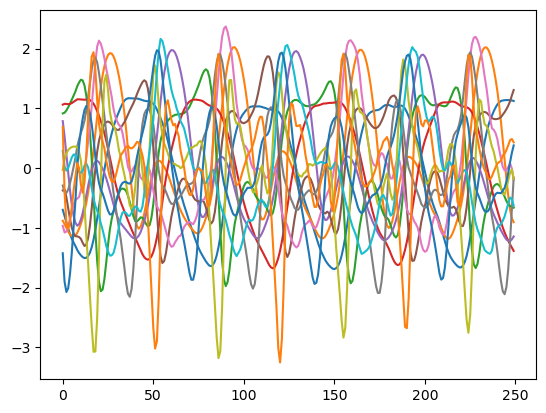

In [20]:
plt.plot(data[11, 0:500:2])

In [6]:
data_tde, τ, k = embed_data(data[:, ::2, :])


In [7]:
plt.plot(data_tde[0, 0:500])

In [8]:
print(f"The data have shape {data_tde.shape}")

In [8]:
# , static_argnames=["timesteps_per_trial", "skip", "t1", "width_size", "hidden_size", "ode_size", "depth", "batch_size", "seed", "print_every", "length_strategy", "lr_strategy", "seeding_strategy", "steps_strategy", "plot","k"
ts, ys, model = jax_utils.train_NODE(
    # model=model,
    data[:, :, :],
    timesteps_per_trial=200,
    t1=2.0,
    width_size=128,
    hidden_size=256,
    ode_size=12,
    depth=3,
    batch_size=128,
    seed=420,
    lr_strategy=(1e-3,),
    steps_strategy=(70000, 30000, 25000),
    length_strategy=(1,),
    skip_strategy=(20,),
    seeding_strategy=(1/2,),
    plot=True,
    print_every=1000,
    k=1,
    use_stabilized_node=False,
    linear=False,
    plot_fn=None,
    # k=max_power+2
)

In [26]:
new_ts = jnp.linspace(0, 20, 2000)
seeding_steps = 100
out = jax.vmap(model, in_axes=(None, 0))(new_ts, data[:, 0:seeding_steps, :])
jnp.save("outputs/real_human_data.npy", data)
jnp.save("outputs/gen_human_data.npy", out)

In [ ]:
for idx in range(data.shape[0]):
    plt.scatter(new_ts, data[idx, :new_ts.shape[0], 0], label="True",s=5, c="black")
    plt.scatter(new_ts, out[idx, :, 0], label="Generated",s=5, c="red")
    plt.legend()
    plt.show()

In [23]:
# Helper functions
@jit
def normalize_signal(signal):
    """Normalize a single signal"""
    mean = jnp.mean(signal)
    std = jnp.std(signal)
    return (signal - mean) / std

# Vectorized version for multiple signals
vnormalize = vmap(normalize_signal, in_axes=0, out_axes=0)

@jit
def euclidean_distance(x, y):
    """Compute euclidean distance between two points"""
    return jnp.sqrt(jnp.sum((x - y) ** 2))

@jit
def cross_correlation(signal1, signal2):
    """Compute normalized cross-correlation for single pair of signals"""
    # Normalize signals
    s1_norm = normalize_signal(signal1)
    s2_norm = normalize_signal(signal2)
    
    # Calculate cross-correlation
    xcorr = jnp.correlate(s1_norm, s2_norm, mode='full')
    
    # Return maximum correlation coefficient
    return jnp.max(jnp.abs(xcorr)) / signal1.shape[0]

# Vectorized version for multiple signal pairs
vcross_correlation = vmap(cross_correlation, in_axes=(0, 0), out_axes=0)

@jit
def fft_comparison(signal1, signal2):
    """Compare frequency components of two signals"""
    # Compute FFTs
    fft1 = jnp.fft.fft(signal1)
    fft2 = jnp.fft.fft(signal2)
    
    # Compare magnitude spectra
    mag1 = jnp.abs(fft1)
    mag2 = jnp.abs(fft2)
    
    # Normalize
    mag1_norm = mag1 / jnp.max(mag1)
    mag2_norm = mag2 / jnp.max(mag2)
    
    return jnp.mean(jnp.abs(mag1_norm - mag2_norm))

# Vectorized version for multiple signal pairs
vfft_comparison = vmap(fft_comparison, in_axes=(0, 0), out_axes=0)

@jit
def simplified_dtw(signal1, signal2, window_size=10):
    """
    Simplified DTW implementation that's JAX-friendly
    Uses a constrained window for better performance
    """
    n, m = signal1.shape[0], signal2.shape[0]
    
    # Initialize cost matrix
    cost_matrix = jnp.full((n + 1, m + 1), jnp.inf)
    cost_matrix = cost_matrix.at[0, 0].set(0)
    
    def scan_fn(prev_row, curr_idx):
        curr_row = jnp.full(m + 1, jnp.inf)
        curr_row = curr_row.at[0].set(jnp.inf)
        
        i = curr_idx + 1
        
        def update_cell(j):
            cost = euclidean_distance(signal1[i-1], signal2[j-1])
            new_cost = cost + jnp.min(jnp.array([
                prev_row[j],
                prev_row[j-1],
                curr_row[j-1]
            ]))
            
            return jax.lax.cond(
                jnp.abs(i - j) <= window_size,
                lambda _: new_cost,
                lambda _: jnp.inf,
                operand=None
            )
        
        j_indices = jnp.arange(1, m + 1)
        costs = vmap(update_cell)(j_indices)
        curr_row = curr_row.at[1:].set(costs)
        
        return curr_row, curr_row
    
    # Scan over all rows
    final_row, _ = jax.lax.scan(
        scan_fn,
        cost_matrix[0],
        jnp.arange(n)
    )
    
    # Return just the final DTW distance
    return final_row[-1]

# Vectorized version for multiple signal pairs
vsimplified_dtw = vmap(simplified_dtw, in_axes=(0, 0), out_axes=0)

@jit
def comprehensive_comparison(signal1, signal2):
    """Compute all metrics for a single pair of signals"""
    return {
        'dtw': simplified_dtw(signal1, signal2),
        'xcorr': cross_correlation(signal1, signal2),
        'fft': fft_comparison(signal1, signal2)
    }

# Example usage with batched data
def batch_compare_signals(signals1, signals2):
    """
    Compare multiple pairs of signals at once
    
    Args:
        signals1: Array of shape (batch_size, signal_length)
        signals2: Array of shape (batch_size, signal_length)
    """
    return {
        'dtw': vsimplified_dtw(signals1, signals2),
        'xcorr': vcross_correlation(signals1, signals2),
        'fft': vfft_comparison(signals1, signals2)
    }

batch_signals1 = jnp.copy(data[:, :new_ts.shape[0], 1])  # shape: (batch_size, signal_length)
batch_signals2 = jnp.copy(out[:, :, 1])  # shape: (batch_size, signal_length)

batch_results = batch_compare_signals(batch_signals1, batch_signals2)

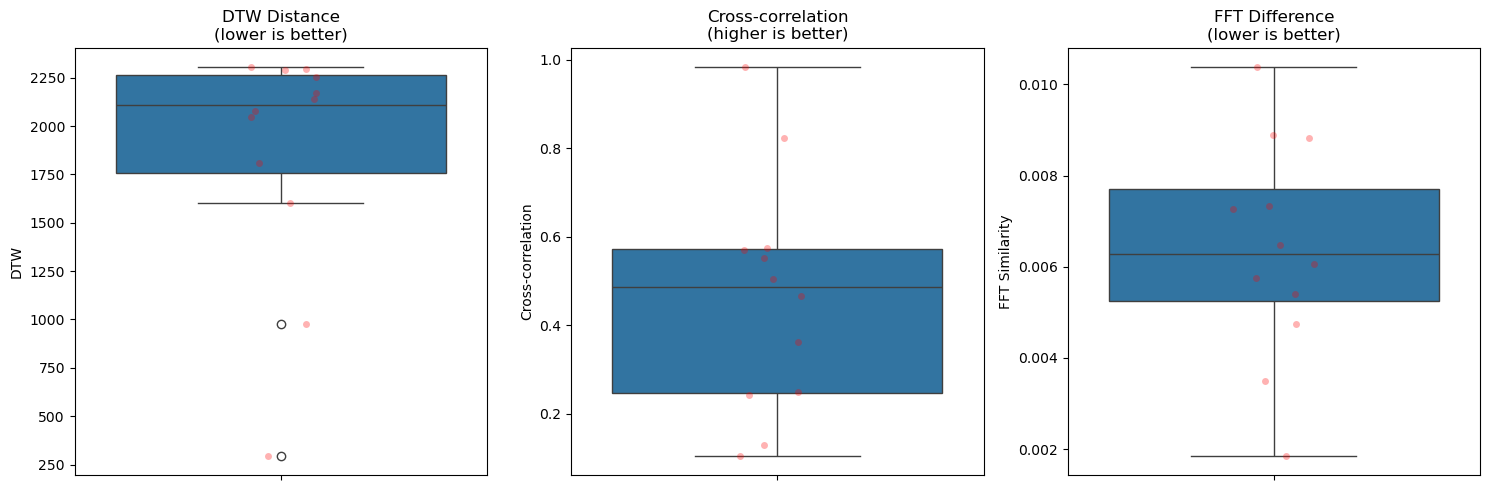


Summary Statistics:
               DTW  Cross-correlation  FFT Similarity      Trial
count    12.000000          12.000000       12.000000  12.000000
mean   1855.509640           0.463480        0.006371   5.500000
std     623.187329           0.265970        0.002392   3.605551
min     296.038914           0.105266        0.001853   0.000000
25%    1758.698456           0.247780        0.005238   2.750000
50%    2109.507113           0.485518        0.006270   5.500000
75%    2262.014152           0.571501        0.007702   8.250000
max    2304.085315           0.983408        0.010377  11.000000


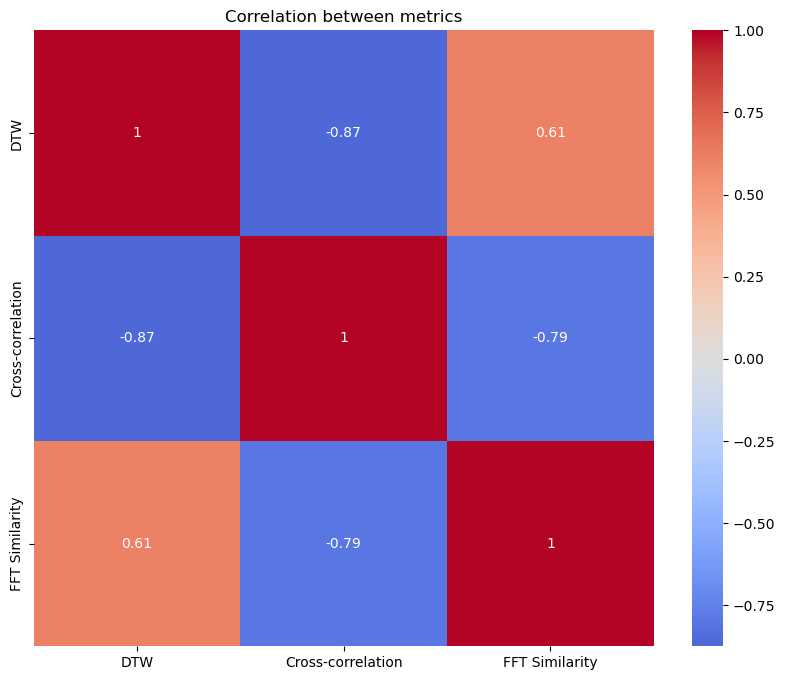

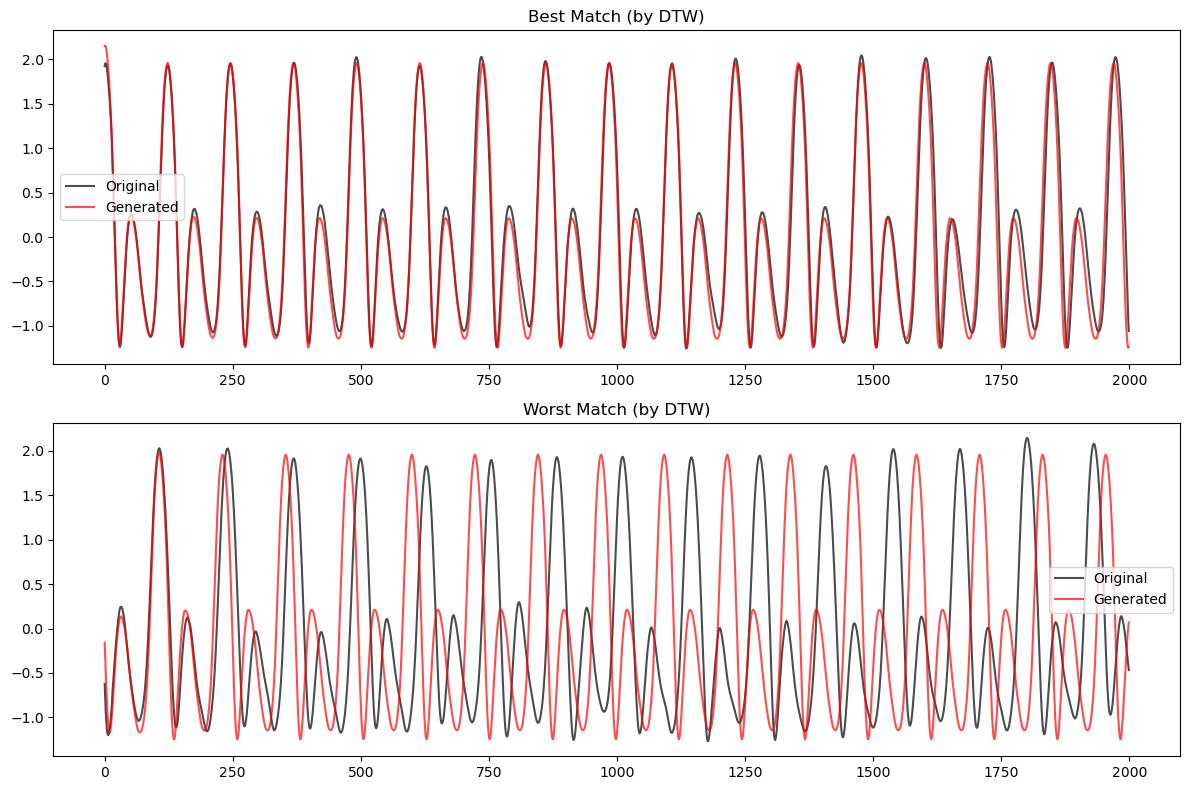

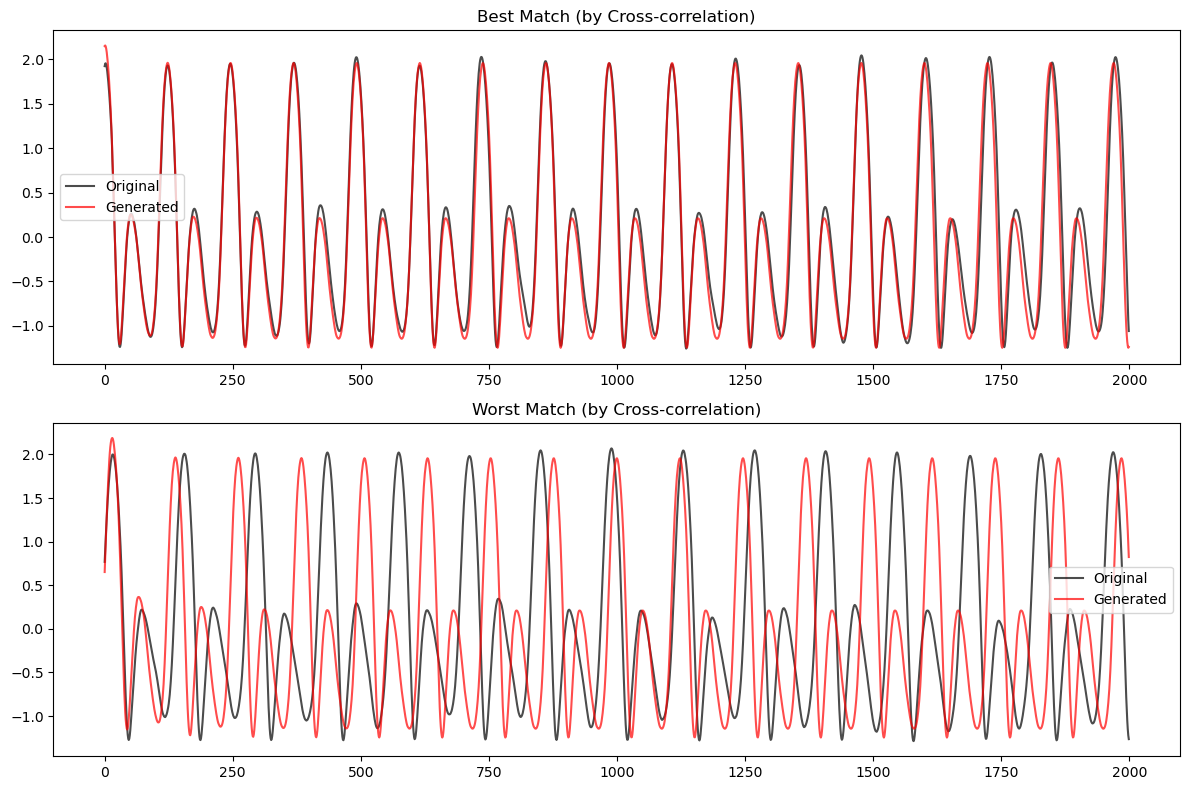

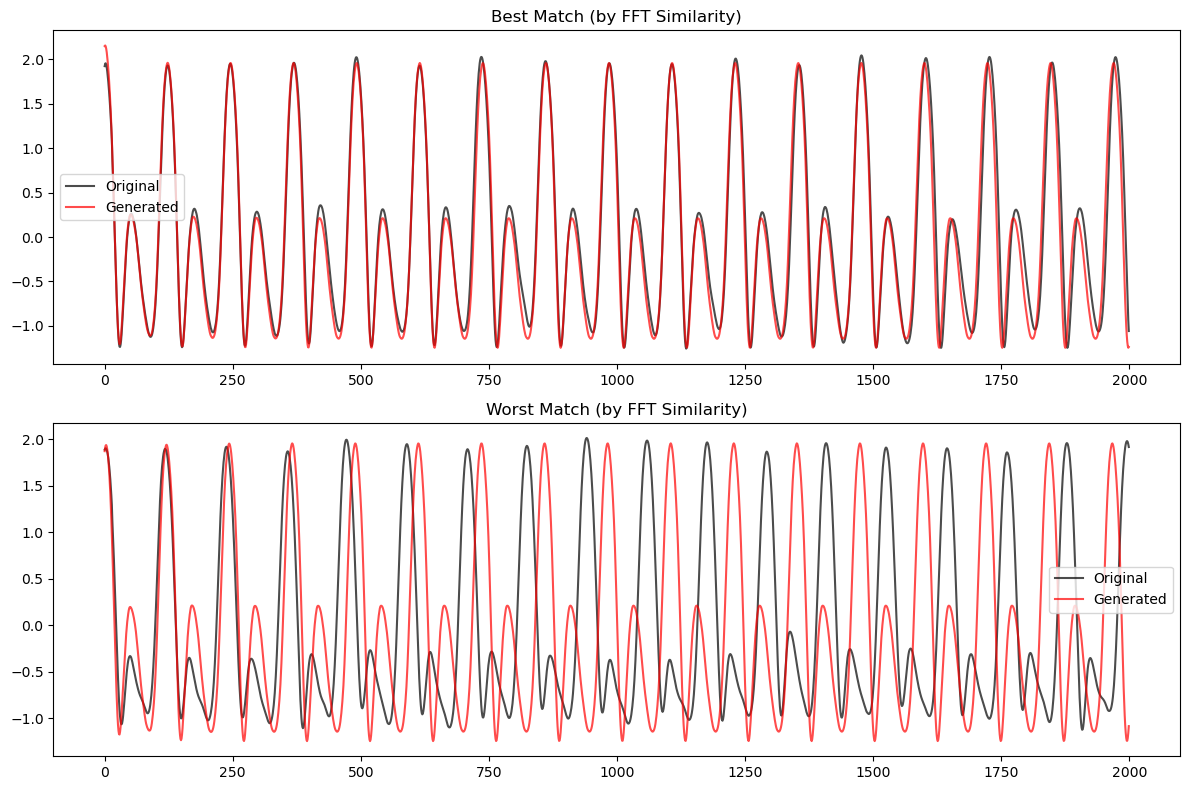

In [24]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert batch results to a DataFrame for easier plotting
def plot_comparison_results(batch_results, figsize=(15, 5)):
    # Create DataFrame
    results_df = pd.DataFrame({
        'DTW': batch_results['dtw'],
        'Cross-correlation': batch_results['xcorr'],
        'FFT Similarity': batch_results['fft'],
        'Trial': range(len(batch_results['dtw']))
    })
    
    # Create subplot for each metric
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # DTW plot (lower is better)
    sns.boxplot(y='DTW', data=results_df, ax=axes[0])
    sns.stripplot(y='DTW', data=results_df, color='red', alpha=0.3, ax=axes[0])
    axes[0].set_title('DTW Distance\n(lower is better)')
    
    # Cross-correlation plot (higher is better)
    sns.boxplot(y='Cross-correlation', data=results_df, ax=axes[1])
    sns.stripplot(y='Cross-correlation', data=results_df, color='red', alpha=0.3, ax=axes[1])
    axes[1].set_title('Cross-correlation\n(higher is better)')
    
    # FFT Similarity plot (lower is better)
    sns.boxplot(y='FFT Similarity', data=results_df, ax=axes[2])
    sns.stripplot(y='FFT Similarity', data=results_df, color='red', alpha=0.3, ax=axes[2])
    axes[2].set_title('FFT Difference\n(lower is better)')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print(results_df.describe())
    
    return results_df

# Plot the results
results_df = plot_comparison_results(batch_results)

# Optional: Plot correlation between metrics
plt.figure(figsize=(10, 8))
sns.heatmap(results_df[['DTW', 'Cross-correlation', 'FFT Similarity']].corr(), 
            annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between metrics')
plt.show()

# Optional: Plot worst and best matches
def plot_extreme_cases(batch_signals1, batch_signals2, results_df, metric='DTW'):
    best_idx = results_df[metric].argmin() if metric in ['DTW', 'FFT Similarity'] else results_df[metric].argmax()
    worst_idx = results_df[metric].argmax() if metric in ['DTW', 'FFT Similarity'] else results_df[metric].argmin()
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Best match
    ax1.plot(batch_signals1[best_idx], label='Original', alpha=0.7, c="black")
    ax1.plot(batch_signals2[best_idx], label='Generated', alpha=0.7, c="red")
    ax1.set_title(f'Best Match (by {metric})')
    ax1.legend()
    
    # Worst match
    ax2.plot(batch_signals1[worst_idx], label='Original', alpha=0.7, c="black")
    ax2.plot(batch_signals2[worst_idx], label='Generated', alpha=0.7, c="red")
    ax2.set_title(f'Worst Match (by {metric})')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# Plot extreme cases for each metric
for metric in ['DTW', 'Cross-correlation', 'FFT Similarity']:
    plot_extreme_cases(batch_signals1, batch_signals2, results_df, metric)